# GERMS-ML
## (Very) Basic sentiment analysis and hyperparameter optimization with Keras

Today, we'll be looking at the paper [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) by Maas et al. In this paper, the authors tested the accuracy of various sentiment-classification algorithms on a sample of 50000 IMDB reviews. This database, called the [ IMDB  (or Large Movie Review Dataset)](http://ai.stanford.edu/~amaas/data/sentiment/), only contains "highly polarized" reviews; that is, reviews with a score below 4 and those with a score above 7. In the paper, the authors achieved an 88.89% accuracy on the IMDB dataset using a variant of SVM. We will see how well we can do by using neural networks. While this may not necessarily be the best model to do so, it will give us a chance to practice building models and performing hyperparameter tuning in Keras.

### Data exploration

`Keras` has [API](https://keras.io/datasets/) for loading the IMDB dataset :

In [1]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data()

Using TensorFlow backend.


Let's look at the size of the sets:

In [2]:
[s.size for s in [x_train, y_train, x_test, y_test]]

[25000, 25000, 25000, 25000]

We see that the training and testing sets were evenly split, and this is how the authors split the data in their paper. We'll keep this split for now, though the impact of the training-test split on our performance is something we can investigate later.

Let's see what each of the data points in `x_train` look like:

In [3]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

Each data point is a list of integers corresponding to the word frequency. For example:

In [4]:
x_train[0][0:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

The first word of the first review is the 1st most frequent word in the data, the second is the 14th most frequent word, etc. 

Let's see how many unique words there are in the dataset. 

In [5]:
import numpy as np
X = np.concatenate((x_train, x_test), axis = 0)

In [6]:
len(np.unique(np.hstack(X)))

88585

So there are 88585 unique words in the data set. 

Let's see what the y values look like:

In [7]:
y_train[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

We see that the targets are either 0 or 1, corresponding to if the review was negative or positive.

Let's examine the data a little more closely. Let's start by looking at the distribution of review lengths:

In [8]:
import pandas as pd
reviews = pd.DataFrame({"review": X})
reviews['length'] = reviews.apply(lambda row: len(row.review), axis = 1)

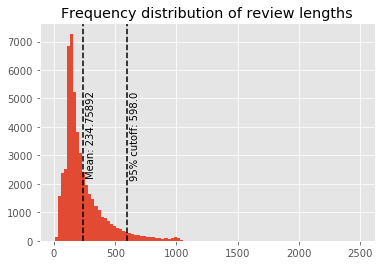

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
reviews.hist(column = "length", bins = 100);
upper_q = reviews.length.quantile(0.95);
review_mean = reviews.length.mean();
plt.axvline(x = upper_q, linestyle = '--', color = 'black');
plt.text(upper_q + 20, 5000, "95% cutoff: {}".format(upper_q),
         rotation = 90);
plt.axvline(x = review_mean, linestyle = '--', color = 'black');
plt.text(review_mean + 30, 5000, "Mean: {}".format(review_mean),
        rotation = 90);
plt.title("Frequency distribution of review lengths");

We see that most of the reviews fall below 300 words, the average is just abotu 235, and that 95% of the reviews are less than 598 words long. We'll use this information later when deciding how many words to use for our classification.

Let's see if there is correlation between review length and review.

In [10]:
Y = np.concatenate((y_train, y_test), axis = 0)
reviews['sentiment'] = Y
reviews['length'].corr(reviews['sentiment'])

0.008232882396842629

Looks like there isn't - that would be too easy. :)

### Q1

* What are some filtering steps we could take when choosing our input data?
* What are some questions you have about the data?
* What are some models we could have built if the correlation between review length and sentiment was high?

## Word embeddings

We'll begin by building a fully-connected neural network, but we first have to decide how we'll input our data into the network. Each review consists of several words - how should our model treat these words? One initial thought would be to one-hot encode each of the words, but that is undesirable because the words have meaning that directly contributes to the sentiment of a review. Perhaps, then, they should treated as categories (ie, mapped to integers, as the data already is). However, this runs into another problem (besides the typical one of the model learning magnitude as important): this doesn't capture relationships between the words.

A area of study called [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) addresses this problem by mapping a corpus of words into a vector space. There are several techniques for doing so (most famously Word2Vec), but they all achieve the goal of decomposing the words of a corpus into a vector space. Once in a vector space, vector arithmetic becomes meaningful. Some famous examples:

* **King - man + woman = queen**: Here, the mapping picked up on the gender of the words as important.
* **Paris - France + Poland = Warsaw**: The embedding picked up on the capital city as important.

For learning more about word embeddings, I recommend:

* [Understanding word vectors](https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469)
* [The Marvelous Mathematics of Computational Linguistics](https://www.technologyreview.com/s/541356/king-man-woman-queen-the-marvelous-mathematics-of-computational-linguistics/)

we'll be using [`Keras`' `embedding` layer](https://keras.io/layers/embeddings/) today to perform the word embedding. We'll talk more about it when we build the model.

### Q2

* What are some questions you have about performing word embedding?


## Building a multi-layer perceptron

We're going to start by building a multi-layer perceptron. We begin by importing the needed packages.

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(489)

In [12]:
max_features = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

We now have to pick the size of our input to our neural network. We see that the reviews are not uniform length - how should we choose our input size? The strategy we will be using is to force the reviews to be of a certain length. We saw earlier that 95% of the reviews were less than 598 words long; thus, we'll transform each of the data points to be 598 words long. For reviews longer than that, we'll ignore the words past 598, and we'll use `sequence.pad_sequences` to 0-pad the review shorter than that cutoff.

In [13]:
max_length = 598
x_train = sequence.pad_sequences(x_train, maxlen = max_length)
x_test = sequence.pad_sequences(x_test, maxlen = max_length)

Now our data is ready to go. Let's build models. We're going to start off with a simple multi-layer perceptron. Note that the first layer will be an `Embedding` layer as discussed in the previous section.

In [14]:
nn = Sequential()
nn.add(Embedding(max_features, 64, 
                    input_length = max_length))
nn.add(Flatten())
nn.add(Dense(125, activation = 'relu'))
nn.add(Dense(64, activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))
nn.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


Let's go ahead and fit the model:

In [54]:
nn_history = nn.fit(x_train, y_train, validation_data = (x_test, y_test),
      epochs = 2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 60s 2ms/step - loss: 0.0225 - acc: 0.9928 - val_loss: 0.6662 - val_acc: 0.8502
Epoch 2/2
25000/25000 [==============================] - 57s 2ms/step - loss: 0.0109 - acc: 0.9964 - val_loss: 0.7884 - val_acc: 0.8516


Let's check our validation accuracy

In [55]:
scores = nn.evaluate(x_test, y_test, verbose = 0)
print("Accuracy: {:.4}".format(scores[1]))

Accuracy: 0.8516


For the amount of work we put in, our result isn't too far off of the 88.79% reported in the Maas paper. What other ways could we improve the accuracy?

Let's do a visualization:

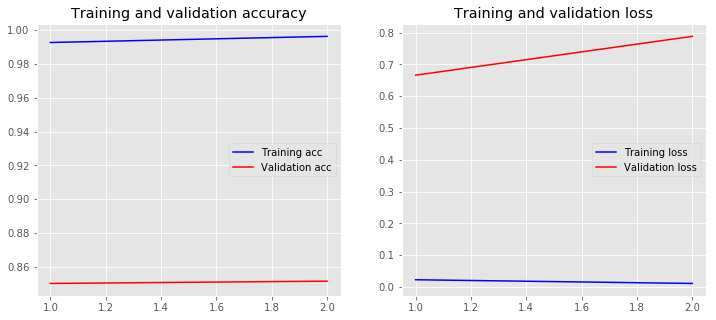

In [56]:
import sys
sys.path.insert(0, '../src')
from gml_utils.visualization import plot_history
plot_history(nn_history)

*Note*: We can see the weight matrix for the word embedding by doing the following:

In [67]:
nn.layers[0].get_weights()

[array([[-0.00209699,  0.00553939, -0.00073237, ...,  0.00583929,
         -0.00385168, -0.00472361],
        [-0.10081855, -0.00297871, -0.0368601 , ...,  0.00294316,
          0.02872147, -0.00658239],
        [-0.003597  ,  0.01577239,  0.01324601, ..., -0.05034737,
          0.00447197, -0.02423627],
        ...,
        [-0.04432647,  0.07158779, -0.01363384, ...,  0.08508951,
          0.03678215, -0.05932579],
        [-0.0721592 , -0.08231144,  0.04334386, ..., -0.05090918,
          0.00657488, -0.02325673],
        [-0.01496676, -0.06692831, -0.06130487, ..., -0.12799256,
          0.03904156,  0.08368525]], dtype=float32)]

### Q3

* What are the charts above telling us? How can we address these issues?
* Check out the [documentation](https://keras.io/datasets/) for the IMDB dataset again - what other fucntions could we use to fine tune our model?
* You can get the weight matrix for the word embedding by doing `nn.layers[0].get_weights()`. How do you interpret this matrix? What are some questions you can answer with this matrix? 

## Hyperparameter optimization

So we have a model up and running and it has decent performance. Let's go ahead and tune the model. [In previous lessons where we were building models using `sklearn`](notebooks/04172019.ipynb), we searched our parameter space by using `GridSearchCV`, which iterated through all the combinations of hyperparameters from the search space we passed it to find the model that performed the best. `Keras` doesn't have a similar function, but we can adapt `sklearn`'s `GridSearchCV` to work on `Keras` models.

To do so, we'll define a function `build_nn` that takes in a set of hyperparameters and returns a neural network with these hyperparameters. First, let's define our hyperparameter search space. For this example, we'll vary the number of hidden layers, the size of the hidden layers, and the dimension of the embedding.

In [36]:
nn_param_grid = [
    {
        'hidden_layers': [1, 2],
        'hidden_layers_size': [64, 125],
        'embedding_dim': [32, 64],
        'epochs': [1]
    }
]

And let's create our function to take in these variables and return the appropriate model:

In [40]:
def build_nn(hidden_layers, hidden_layers_size, embedding_dim):
    """
    Builds a fully-connected neural network with the passed hyperparameters.
    """
    from keras.models import Sequential
    from keras.layers import Dense, Flatten
    from keras.layers.embeddings import Embedding
    model = Sequential()
    model.add(Embedding(5000, embedding_dim, 
                        input_length = 598))
    model.add(Flatten())
    for i in range(hidden_layers):
        model.add(Dense(hidden_layers_size, activation = 'relu'))
        
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

    return(model)

Now that we have our `build_nn` function, we're almost ready to perform our GridSearch..

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
nn_model = KerasClassifier(build_nn)
nn_gridsearch = GridSearchCV(estimator = nn_model, 
                             param_grid = nn_param_grid,
                             n_jobs = -1,
                             verbose = 2)

Now, just like with the `sklearn` models, we can call `fit` on the `GridSearch` object *(warning: this will take a while)*:

In [42]:
nn_gridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  8.7min finished


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
25000/25000 [==============================] - 27s 1ms/step - loss: 0.3961 - acc: 0.8021


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000179C749A358>,
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'hidden_layers': [1, 2], 'hidden_layers_size': [64, 125], 'embedding_dim': [32, 64], 'epochs': [1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Once the grid search is complete, we can use all the object's methods as we are used to:

In [44]:
nn_gridsearch.best_score_

0.8731199999952316

In [45]:
nn_gridsearch.best_params_

{'embedding_dim': 32,
 'epochs': 1,
 'hidden_layers': 2,
 'hidden_layers_size': 125}

### Q4

* In general, what modeling choices are we making? How does this impact our model?
* What are your next steps for fine-tuning the model?
* What other models might be appropriate for this task?